In [1]:
# k crossover d，close > ema 8, ema 8 > ema 14, ema 14 > 50, take profit 2 atr, stop loss 3 atr
# ! conda install -c conda-forge ta --yes

In [2]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '1h'

# start epoch till now
start_time = 1672570703000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [4]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    rawdf = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        rawdf = pd.concat([rawdf, out], axis = 0)
    
    rawdf = rawdf[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    rawdf = rawdf.astype(convert_dict)
    
    rawdf['Close_Time'] = pd.to_datetime(rawdf['Close_Time'], unit = 'ms')
    rawdf['Close_Time'] = rawdf['Close_Time'] + pd.Timedelta(hours=timezone)
    rawdf['Close_Time'] = rawdf['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    rawdf = rawdf.reset_index(drop=True)
    
    return rawdf

In [5]:
rawdf = get_historical(symbol, interval, start_time, end_time, step)
print(rawdf)

               Close_Time     Open    Close     High      Low      Volume
0     2023-01-01 19:59:59  1197.14  1196.34  1197.41  1195.72   2854.0542
1     2023-01-01 20:59:59  1196.35  1197.17  1198.50  1195.83   4418.7365
2     2023-01-01 21:59:59  1197.16  1195.26  1197.29  1193.54   4804.4490
3     2023-01-01 22:59:59  1195.26  1194.50  1195.86  1194.20   3496.2584
4     2023-01-01 23:59:59  1194.50  1196.81  1196.81  1194.34   2771.4134
...                   ...      ...      ...      ...      ...         ...
1961  2023-03-24 12:59:59  1812.35  1804.50  1815.29  1803.12  33401.9297
1962  2023-03-24 13:59:59  1804.50  1811.88  1813.62  1804.16  10406.0731
1963  2023-03-24 14:59:59  1811.87  1813.26  1814.82  1810.51   8944.4215
1964  2023-03-24 15:59:59  1813.26  1815.18  1817.48  1809.11  17660.9299
1965  2023-03-24 16:59:59  1815.18  1805.64  1816.61  1805.00   4611.8929

[1966 rows x 6 columns]


In [6]:
df = rawdf.copy()

In [7]:
def indicators(df):

# ema
    for i in (8, 14, 50):
        df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# atr
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)

# kd
    kd_int = 14
    d_int = 3
   
    kddf = pd.DataFrame()
    kddf[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kddf[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slowk'] = (df['Close'] - kddf[str(kd_int) + '-Low'])*100/(kddf[str(kd_int) + '-High'] - kddf[str(kd_int) + '-Low'])
    df['slowd'] = df['slowk'].rolling(d_int).mean()
    
    
# rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()

    return df

def checkcross(df):
    series = df['slowk'] > df['slowd']
    return series.diff() & series

In [8]:
indicators(df)
df['kd_cross'] = checkcross(df)
print(df)

               Close_Time     Open    Close     High      Low      Volume  \
0     2023-01-01 19:59:59  1197.14  1196.34  1197.41  1195.72   2854.0542   
1     2023-01-01 20:59:59  1196.35  1197.17  1198.50  1195.83   4418.7365   
2     2023-01-01 21:59:59  1197.16  1195.26  1197.29  1193.54   4804.4490   
3     2023-01-01 22:59:59  1195.26  1194.50  1195.86  1194.20   3496.2584   
4     2023-01-01 23:59:59  1194.50  1196.81  1196.81  1194.34   2771.4134   
...                   ...      ...      ...      ...      ...         ...   
1961  2023-03-24 12:59:59  1812.35  1804.50  1815.29  1803.12  33401.9297   
1962  2023-03-24 13:59:59  1804.50  1811.88  1813.62  1804.16  10406.0731   
1963  2023-03-24 14:59:59  1811.87  1813.26  1814.82  1810.51   8944.4215   
1964  2023-03-24 15:59:59  1813.26  1815.18  1817.48  1809.11  17660.9299   
1965  2023-03-24 16:59:59  1815.18  1805.64  1816.61  1805.00   4611.8929   

            ema_8       ema_14       ema_50        atr      slowk      slow

               Close_Time     Open    Close     High      Low      Volume  \
0     2023-01-01 19:59:59  1197.14  1196.34  1197.41  1195.72   2854.0542   
1     2023-01-01 20:59:59  1196.35  1197.17  1198.50  1195.83   4418.7365   
2     2023-01-01 21:59:59  1197.16  1195.26  1197.29  1193.54   4804.4490   
3     2023-01-01 22:59:59  1195.26  1194.50  1195.86  1194.20   3496.2584   
4     2023-01-01 23:59:59  1194.50  1196.81  1196.81  1194.34   2771.4134   
...                   ...      ...      ...      ...      ...         ...   
1961  2023-03-24 12:59:59  1812.35  1804.50  1815.29  1803.12  33401.9297   
1962  2023-03-24 13:59:59  1804.50  1811.88  1813.62  1804.16  10406.0731   
1963  2023-03-24 14:59:59  1811.87  1813.26  1814.82  1810.51   8944.4215   
1964  2023-03-24 15:59:59  1813.26  1815.18  1817.48  1809.11  17660.9299   
1965  2023-03-24 16:59:59  1815.18  1805.64  1816.61  1805.00   4611.8929   

            ema_8       ema_14       ema_50        atr      slowk      slow

LinAlgError: SVD did not converge in Linear Least Squares

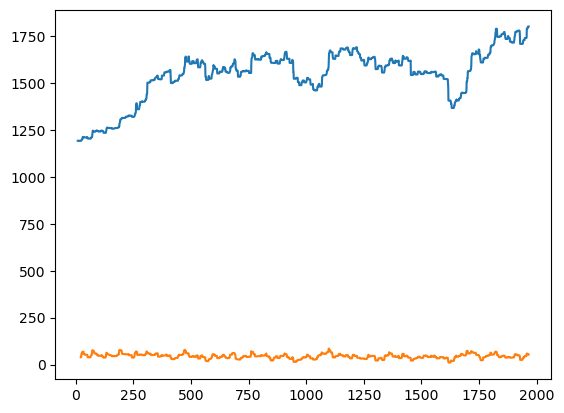

In [10]:
# Identify recent price lows and RSI lows
lookback_period = 10
df['rolling_low'] = df['Low'].rolling(window=lookback_period).min()
df['rsi_low'] = df['rsi'].rolling(window=lookback_period).min()

# Plot the recent price lows and RSI lows
plt.plot(df['rolling_low'], label='Price Low')
plt.plot(df['rsi_low'], label='RSI Low')

print(df)

# Calculate the slopes of the lines
price_slope = np.polyfit(range(len(df.index)), df['rolling_low'], 1)[0]
rsi_slope = np.polyfit(range(len(df.index)), df['rsi_low'], 1)[0]

# Check for bullish or bearish divergence
if price_slope > 0 and rsi_slope < 0:
    print('Bullish divergence detected.')
elif price_slope < 0 and rsi_slope > 0:
    print('Bearish divergence detected.')
else:
    print('No divergence detected.')

# Show the plot
plt.legend()
plt.show()

In [ ]:
def conditions(df):
    # k crossover d，close > ema 8, ema 8 > ema 14, ema 14 > 50, take profit 2 atr, stop loss 3 atr

    for index, row in df.iterrows():
        # c1
        df['c1'] = df['kd_cross']
        # c2
        df['c2'] = df['Close'] >= df['ema_8']
        # c3
        df['c3'] = df['ema_8'] >= df['ema_14']
        # c4
        df['c4'] = df['ema_14'] >= df['ema_50']
            

    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3 & df.c4, 'signal'] = True


    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [ ]:
conditions(df)

In [ ]:
buydf = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan
close_val = buydf['Close']
atr_val = buydf['atr']

for index, row in buydf.iterrows():

    if index == 0:
        continue
        
        # set entry price
        # set stop loss
        # 進場
    
    elif buydf.at[index, 'openbuy'] == True:
   
        buydf.at[index, 'entry_p'] = close_val.shift(1).at[index]
        buydf.at[index, 'stop_loss'] = close_val.shift(1).at[index] - 1.5 * atr_val.shift(1).at[index]
        buydf.at[index, 'take_profit'] = close_val.shift(1).at[index] + 2.5 * atr_val.shift(1).at[index]
        buydf.at[index, 'position'] = 'Buy'
        buydf.at[index, 'status'] = 'Pending'
        in_position = True
        stop_loss = buydf.at[index, 'stop_loss']
    
for index, row in buydf.iterrows():
    # Check if the jth row's status is 'Pending'
    if df.loc[index, 'status'] == 'Pending':
        for j in range(index, len(buydf)):
            if df.loc[j, 'High'] >= df.loc[index, 'take_profit']:
                # If the price is higher, calculate the profit
                profit = df.loc[index, 'take_profit'] - df.loc[index, 'entry_p']
                # Set the 'Status' column in the jth row to 'Sold'
                df.loc[index, 'status'] = 'Sell'
                # Set the 'take_profit' column in the jth row to the calculated profit
                df.loc[index, 'profit'] = profit
                break

            if df.loc[j, 'Close'] <= df.loc[index, 'stop_loss']:
                profit = df.loc[index, 'stop_loss'] - df.loc[index, 'entry_p']
                df.loc[index, 'status'] = 'Stop'
                df.loc[index, 'profit'] = profit
                break
        
for index, row in buydf.iterrows():

    if df.loc[index, 'status'] == 'Pending':
        df.loc[index, 'profit'] = 0

    
buydf.to_csv('buydf.csv')

raw_entry_df = buydf.copy()


# 過濾有訊號或事件發生的Ｋ線
buydf = buydf[(buydf['openbuy'] == True) |
              (buydf['signal'] == True) | 
              (buydf['position'] == 'Buy') |
              (buydf['position'] == 'Sell') |
              (buydf['position'] == 'Stop')]


print(buydf)


In [ ]:
# 部位回測

posdf = buydf.copy()
posdf = posdf.reset_index(drop = True)
posdf = posdf[(posdf['position'] == 'Buy')]


col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'atr', 'position', 'entry_p', 'stop_loss', 'take_profit', 'status', 'profit']
pos = posdf[col]
pos = pos.reset_index(drop = True)

        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
entry_size = 1
fee = 0.03 / 100
entry_amt = pos.entry_p.sum() * entry_size
SL_amt = pos.loc[pos.status == 'Stop', 'stop_loss'].sum() * entry_size
TP_amt = pos.loc[pos.status == 'Sell', 'take_profit'].sum() * entry_size
ttl_fee = (entry_amt + SL_amt + TP_amt) * fee

# 損益
leverage = 10
ttl_profit = pos.profit.sum() * entry_size - ttl_fee

wins = pos['status'].str.count('Sell').sum()
loses = pos['status'].str.count('Stop').sum()
win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)

result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)



In [ ]:
plt_df = raw_entry_df.copy()

plt.figure(figsize=(80, 54))
plt.ylabel('Close')
plt.plot(plt_df.Close, label = 'Close')
plt.plot(plt_df.entry_p, 'ro', label = 'Entry', markersize=10)
plt.plot(plt_df.ema_8, label='ema_8', c='g', lw=0.5)
plt.plot(plt_df.ema_14, label='ema_14', c='r', lw=0.5)
plt.plot(plt_df.ema_50, label='ema_50', c='b', lw=0.5)
plt.legend()
plt.show()